In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

#from subprocess import check_output
#print(check_output(["ls", "../input"]).decode("utf8"))

import seaborn as sns # Good visualization library
import matplotlib.pyplot as plt # Basic visualisation library
%matplotlib inline

from sklearn.preprocessing import LabelEncoder # For converting the objects into numbers
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
import xgboost
# Any results you write to the current directory are saved as output.

D:\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [257]:
raw_train=pd.read_csv('D:/GitHub Repositories/Titanic_dataset_Kaggle/Kaggle-Titanic-Disaster-Dataset/train.csv', index_col = 'PassengerId')
raw_test=pd.read_csv('../input/test.csv', index_col = 'PassengerId')

In [258]:
raw_train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [259]:
raw_train.shape

(891, 11)

In [260]:
raw_train.dtypes  # Finding the datatypes of the dataset

Survived      int64
Pclass        int64
Name         object
Sex          object
Age         float64
SibSp         int64
Parch         int64
Ticket       object
Fare        float64
Cabin        object
Embarked     object
dtype: object

In [261]:
raw_train.isnull().sum() # Finding the number of null values in the dataset

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [262]:
# Cleaning of dataframe given to us

# Filling the null values of embarked columns with the mode
def fill_embarked_na(df):
    df['Embarked'].fillna(df['Embarked'].mode()[0], inplace= True)

# Filling the null values of cabin column with the N    
def fill_cabin_na(df):
    df['Cabin'].fillna('No_Cabin'[0], inplace= True)
        
# Filling the age column with the median grouped by sex
def fill_age_na(df):
    df.loc[df.Age.isnull(), 'Age'] = df.groupby('Sex').Age.transform('median')
        
# Making a new column family members
def family_members(df):
    df['Family_members'] = df['Parch'] + df['SibSp'] + 1
        
def modify_sex_column(df):
    df["Sex"] = df["Sex"].apply(lambda sex: 1 if sex == 'male' else 0)
    
def is_alone(df):
    df['Is_alone'] = 0
    df["Is_alone"].loc[df['Family_members'] < 2] = 1
    
def has_cabin(df):
    df['Has_cabin'] = 1
    df["Has_cabin"].loc[df["Cabin"] != "N"] = 0

In [263]:
# Calling all the functions made to clean the data

fill_embarked_na(raw_train)
fill_cabin_na(raw_train)
fill_age_na(raw_train)
family_members(raw_train)
is_alone(raw_train)
modify_sex_column(raw_train)
has_cabin(raw_train)

/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [264]:
raw_train.isnull().sum()   # Checking the dataframe once more

Survived          0
Pclass            0
Name              0
Sex               0
Age               0
SibSp             0
Parch             0
Ticket            0
Fare              0
Cabin             0
Embarked          0
Family_members    0
Is_alone          0
Has_cabin         0
dtype: int64

In [265]:
raw_train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family_members,Is_alone,Has_cabin
PassengerId,,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,N,S,2,0,1
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C85,C,2,0,0
3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,N,S,1,1,1
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,C123,S,2,0,0
5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,N,S,1,1,1


In [266]:
name = raw_train.Name
def include_title(name):
    if '.' in name:
        return name.split(',')[1].split('.')[0].strip()
    else:
        return 'Unknown'
titles = sorted(set([x for x in raw_train.Name.map(lambda x: include_title(x))]))

def replace_titles(x):
    title = x['Title']
    if title in ['Capt', 'Col', 'Don', 'Jonkheer', 'Major', 'Rev', 'Sir']:
        return 'Mr'
    elif title in ['the Countess', 'Mme', 'Lady']:
        return 'Mrs'
    elif title in ['Mlle', 'Ms']:
        return 'Miss'
    elif title =='Dr':
        if x['Sex']=='male':
            return 'Mr'
        else:
            return 'Mrs'
    else:
        return title
raw_train['Title'] = raw_train['Name'].map(lambda x: include_title(x))

In [267]:
raw_train['Title'] = raw_train.apply(replace_titles, axis=1)

In [268]:
raw_train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family_members,Is_alone,Has_cabin,Title
PassengerId,,,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,N,S,2,0,1,Mr
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C85,C,2,0,0,Mrs
3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,N,S,1,1,1,Miss
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,C123,S,2,0,0,Mrs
5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,N,S,1,1,1,Mr


In [269]:
raw_train.Title.unique()

array(['Mr', 'Mrs', 'Miss', 'Master'], dtype=object)

In [270]:
raw_train.dtypes

Survived            int64
Pclass              int64
Name               object
Sex                 int64
Age               float64
SibSp               int64
Parch               int64
Ticket             object
Fare              float64
Cabin              object
Embarked           object
Family_members      int64
Is_alone            int64
Has_cabin           int64
Title              object
dtype: object

In [271]:
raw_train.drop(['Name', 'Ticket', 'Cabin', 'SibSp', 'Parch'], axis = 1, inplace = True)
x = raw_train.columns
x

Index(['Survived', 'Pclass', 'Sex', 'Age', 'Fare', 'Embarked',
       'Family_members', 'Is_alone', 'Has_cabin', 'Title'],
      dtype='object')

In [272]:
# Label Encoding
le = LabelEncoder()

def label_encoding(df):
    df["Embarked"] = le.fit_transform(df["Embarked"])
    df["Title"] = le.fit_transform(df["Title"])

In [273]:
label_train = raw_train

In [274]:
raw_test.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [275]:
raw_test.isnull().sum()

Pclass        0
Name          0
Sex           0
Age          86
SibSp         0
Parch         0
Ticket        0
Fare          1
Cabin       327
Embarked      0
dtype: int64

In [276]:
# Calling all the functions made to clean the test data

fill_embarked_na(raw_test)
fill_cabin_na(raw_test)
fill_age_na(raw_test)
family_members(raw_test)
is_alone(raw_test)
modify_sex_column(raw_test)
has_cabin(raw_test)
#raw_test['Title'] = raw_test.apply(replace_titles, axis=1)

/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [277]:
name = raw_test.Name
titles = sorted(set([x for x in raw_test.Name.map(lambda x: include_title(x))]))
raw_test['Title'] = raw_test['Name'].map(lambda x: include_title(x))
raw_test['Title'] = raw_test.apply(replace_titles, axis=1)

In [278]:
label_encoding(label_train)
label_train.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Family_members,Is_alone,Has_cabin,Title
PassengerId,,,,,,,,,,
1,0,3,1,22.0,7.2500,2,2,0,1,2
2,1,1,0,38.0,71.2833,0,2,0,0,3
3,1,3,0,26.0,7.9250,2,1,1,1,1
4,1,1,0,35.0,53.1000,2,2,0,0,3
5,0,3,1,35.0,8.0500,2,1,1,1,2


In [279]:
raw_test.drop(['Name', 'Ticket', 'Cabin', 'SibSp', 'Parch'], axis = 1, inplace = True)
raw_test["Fare"].fillna(raw_test["Fare"].mean(), inplace=True)
print(raw_test.isnull().sum())
label_test = raw_test
label_encoding(label_test)
label_test.head()

Pclass            0
Sex               0
Age               0
Fare              0
Embarked          0
Family_members    0
Is_alone          0
Has_cabin         0
Title             0
dtype: int64


,Pclass,Sex,Age,Fare,Embarked,Family_members,Is_alone,Has_cabin,Title
PassengerId,,,,,,,,,
892,3,1,34.5,7.8292,1,1,1,1,3
893,3,0,47.0,7.0000,2,2,0,1,4
894,2,1,62.0,9.6875,1,1,1,1,3
895,3,1,27.0,8.6625,2,1,1,1,3
896,3,0,22.0,12.2875,2,3,0,1,4


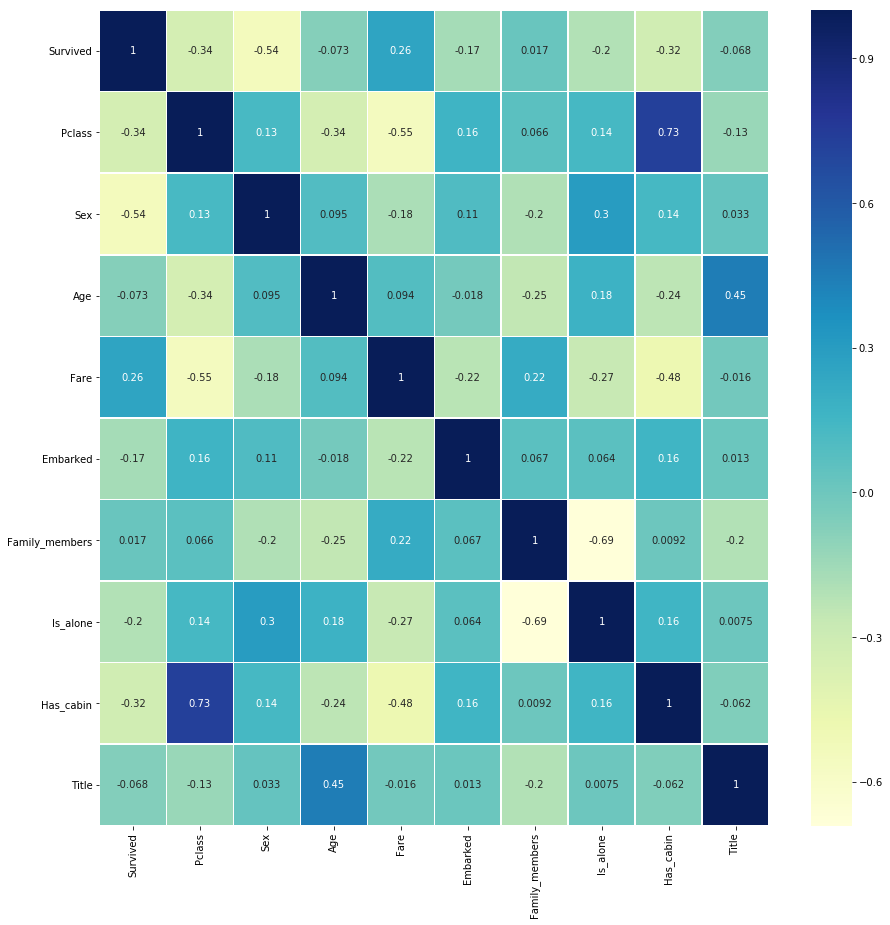

In [280]:
plt.figure(figsize = (15,15))
sns.heatmap(label_train.corr(), linewidths = .5, annot= True, cmap="YlGnBu")

In [281]:
x = label_train.drop('Survived', axis =1)
y = label_train['Survived']
x_label_train, x_label_test, y_label_train, y_label_test = train_test_split(x, y, test_size=0.20)

In [282]:
# Logistic Regressiom Model
lr = LogisticRegression(C = 1)
print(lr.fit(x_label_train, y_label_train))

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


In [283]:
print("Accuracy of Logit Model on train:",accuracy_score(y_label_train, lr.predict(x_label_train)))
print("Accuracy of Logit Model on test:",accuracy_score(y_label_test, lr.predict(x_label_test)))

Accuracy of Logit Model on train: 0.793539325843
Accuracy of Logit Model on test: 0.837988826816


In [284]:
score_lr = cross_val_score(lr, x.values, y.values, cv=5)
print("Cross Validation score : " + str(score_lr))
print("Cross Validation Mean score : " + str(score_lr.mean()))

Cross Validation score : [ 0.78212291  0.79888268  0.78089888  0.78651685  0.8079096 ]
Cross Validation Mean score : 0.79126618429


In [285]:
# Decision Tree Classifier Model
tree = DecisionTreeClassifier(criterion = 'entropy', max_depth = 11)
print(tree.fit(x_label_train, y_label_train))

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=11,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


In [286]:
print("Accuracy of Decision Tree Model on train:",accuracy_score(y_label_train, tree.predict(x_label_train)))
print("Accuracy of Decision Tree Model on test:",accuracy_score(y_label_test, tree.predict(x_label_test)))

Accuracy of Decision Tree Model on train: 0.926966292135
Accuracy of Decision Tree Model on test: 0.832402234637


In [287]:
score_tree = cross_val_score(tree, x.values, y.values, cv=5)
print("Cross Validation score : " + str(score_tree))
print("Cross Validation Mean score : " + str(score_tree.mean()))

Cross Validation score : [ 0.82122905  0.7877095   0.83146067  0.79775281  0.83615819]
Cross Validation Mean score : 0.814862044544


In [288]:
# Random Forest Classifier Model
forest = RandomForestClassifier(n_estimators = 1000, criterion = 'entropy', max_depth = 5, 
                                min_samples_split = 3)
print(forest.fit(x_label_train, y_label_train))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=3,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [289]:
print("Accuracy of Random Forest Model on train:",accuracy_score(y_label_train, forest.predict(x_label_train)))
print("Accuracy of Random Forest Model on test:",accuracy_score(y_label_test, forest.predict(x_label_test)))

Accuracy of Random Forest Model on train: 0.859550561798
Accuracy of Random Forest Model on test: 0.849162011173


Text(33,0.5,'Actual')

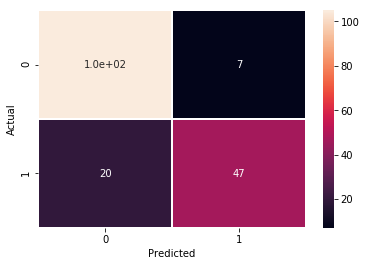

In [322]:
# Using confusion matrix to validate the model
conf = confusion_matrix(y_label_test, forest.predict(x_label_test))
sns.heatmap(conf, linewidths = 0.5, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')

In [328]:
print(forest.predict(label_test))
forest_pred= pd.DataFrame({'PassengerId' : np.arange(892,1310), 'Survived': forest.predict(label_test)})

[0 0 0 0 1 0 0 0 1 0 0 0 1 0 1 1 0 0 0 0 0 1 1 0 1 0 1 0 1 0 0 0 1 1 1 0 0
 0 0 0 0 1 0 1 1 0 1 0 1 1 1 0 1 1 0 0 0 0 0 1 0 0 0 1 1 1 0 0 1 1 1 0 0 1
 1 1 0 1 0 1 1 0 0 0 0 0 1 0 1 1 1 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 1 1 1 1 0 0 1 1 1 1 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0
 0 0 1 0 0 0 0 0 1 0 1 0 1 1 1 0 0 1 1 0 1 0 0 0 0 0 0 1 1 1 1 1 0 1 1 0 1
 0 1 0 0 0 0 0 1 0 1 0 1 0 0 0 1 1 1 1 0 0 0 0 1 0 0 0 0 1 0 0 1 0 1 0 1 0
 1 0 1 0 0 1 0 0 0 1 0 0 1 0 1 0 1 1 1 1 1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 1
 0 0 0 1 1 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 1 1 0 1 0 0 1 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 1 0
 1 0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 1 1 0 0 0 1 0 1 0 0 0 0 1 1 0 1 0 0 0 1 0
 0 1 0 0 1 1 0 0 0 0 0 0 1 1 0 1 0 0 0 0 1 1 1 0 0 1 0 1 0 0 1 0 1 0 1 0 0
 0 1 1 1 1 0 0 1 0 0 1]


In [329]:
forest_pred.to_csv('Titanic_Submission_Random_forrest.csv', index=False)

In [290]:
score_forest = cross_val_score(forest, x.values, y.values, cv=5)
print("Cross Validation score : " + str(score_forest))
print("Cross Validation Mean score : " + str(score_forest.mean()))

Cross Validation score : [ 0.82681564  0.82122905  0.82022472  0.79775281  0.85310734]
Cross Validation Mean score : 0.823825913092


In [291]:
# Extra Trees Classifier Model
extra_tree = ExtraTreesClassifier(n_estimators = 1000, criterion = 'entropy', max_depth = 5, 
                                  min_samples_split = 3)
print(extra_tree.fit(x_label_train, y_label_train))

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=5, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=3,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)


In [292]:
print("Accuracy of Extra Tree Model on train:",accuracy_score(y_label_train, extra_tree.predict(x_label_train)))
print("Accuracy of Extra Tree Model on test:",accuracy_score(y_label_test, extra_tree.predict(x_label_test)))

Accuracy of Extra Tree Model on train: 0.839887640449
Accuracy of Extra Tree Model on test: 0.871508379888


In [293]:
score_extra_tree = cross_val_score(extra_tree, x.values, y.values, cv=5)
print("Cross Validation score : " + str(score_extra_tree))
print("Cross Validation Mean score : " + str(score_extra_tree.mean()))

Cross Validation score : [ 0.83240223  0.81005587  0.8258427   0.79775281  0.85875706]
Cross Validation Mean score : 0.824962133665


In [294]:
# KNN Model
knn = KNeighborsClassifier(n_neighbors = 29, weights ='distance')
print(knn.fit(x_label_train, y_label_train))

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=29, p=2,
           weights='distance')


In [295]:
print("Accuracy of KNN Model on train:",accuracy_score(y_label_train, knn.predict(x_label_train)))
print("Accuracy of KNN Model on test:",accuracy_score(y_label_test, knn.predict(x_label_test)))

Accuracy of KNN Model on train: 0.98595505618
Accuracy of KNN Model on test: 0.754189944134


In [296]:
score_knn = cross_val_score(knn, x.values, y.values, cv=5)
print("Cross Validation score : " + str(score_knn))
print("Cross Validation Mean score : " + str(score_knn.mean()))

Cross Validation score : [ 0.63687151  0.75977654  0.74157303  0.73033708  0.76271186]
Cross Validation Mean score : 0.726254004292


In [297]:
knn2 = KNeighborsClassifier(n_neighbors = 15, weights ='distance')
print(knn2.fit(x_label_train, y_label_train))
print("Accuracy of KNN Model on train:",accuracy_score(y_label_train, knn2.predict(x_label_train)))
print("Accuracy of KNN Model on test:",accuracy_score(y_label_test, knn2.predict(x_label_test)))

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=15, p=2,
           weights='distance')
Accuracy of KNN Model on train: 0.98595505618
Accuracy of KNN Model on test: 0.759776536313


In [298]:
score_knn2 = cross_val_score(knn2, x.values, y.values, cv=5)
print("Cross Validation score : " + str(score_knn2))
print("Cross Validation Mean score : " + str(score_knn2.mean()))

Cross Validation score : [ 0.62569832  0.74860335  0.74157303  0.71348315  0.73446328]
Cross Validation Mean score : 0.712764226518


In [299]:
# SVM Model
svc = SVC(C=1, kernel = 'sigmoid')
print(svc.fit(x_label_train, y_label_train))

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='sigmoid',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [300]:
print("Accuracy of SVM Model on train:",accuracy_score(y_label_train, svc.predict(x_label_train)))
print("Accuracy of SVM Model on test:",accuracy_score(y_label_test, svc.predict(x_label_test)))

Accuracy of SVM Model on train: 0.613764044944
Accuracy of SVM Model on test: 0.625698324022


In [301]:
score_svc = cross_val_score(svc, x.values, y.values, cv=5)
print("Cross Validation score : " + str(score_svc))
print("Cross Validation Mean score : " + str(score_svc.mean()))

Cross Validation score : [ 0.61452514  0.61452514  0.61797753  0.61797753  0.61581921]
Cross Validation Mean score : 0.61616490891


In [302]:
#Adaboost Model
ada = AdaBoostClassifier(learning_rate = 0.1)
print(ada.fit(x_label_train, y_label_train))

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.1, n_estimators=50, random_state=None)


In [303]:
print("Accuracy of SVM Model on train:",accuracy_score(y_label_train, ada.predict(x_label_train)))
print("Accuracy of SVM Model on test:",accuracy_score(y_label_test, ada.predict(x_label_test)))

Accuracy of SVM Model on train: 0.818820224719
Accuracy of SVM Model on test: 0.849162011173


In [304]:
score_ada = cross_val_score(ada, x.values, y.values, cv=5)
print("Cross Validation score : " + str(score_ada))
print("Cross Validation Mean score : " + str(score_ada.mean()))

Cross Validation score : [ 0.83798883  0.82122905  0.80898876  0.79775281  0.81920904]
Cross Validation Mean score : 0.817033697935


In [305]:
# Gradient Boosting Algorithm
gbc = GradientBoostingClassifier()
print(gbc.fit(x_label_train, y_label_train))

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)


In [306]:
print("Accuracy of GBC Model on train:",accuracy_score(y_label_train, gbc.predict(x_label_train)))
print("Accuracy of GBC Model on test:",accuracy_score(y_label_test, gbc.predict(x_label_test)))

Accuracy of GBC Model on train: 0.908707865169
Accuracy of GBC Model on test: 0.843575418994


In [307]:
score_gbc = cross_val_score(gbc, x.values, y.values, cv=5)
print("Cross Validation score : " + str(score_gbc))
print("Cross Validation Mean score : " + str(score_gbc.mean()))

Cross Validation score : [ 0.83240223  0.82122905  0.85955056  0.79775281  0.85875706]
Cross Validation Mean score : 0.83393834357


Text(33,0.5,'Actual')

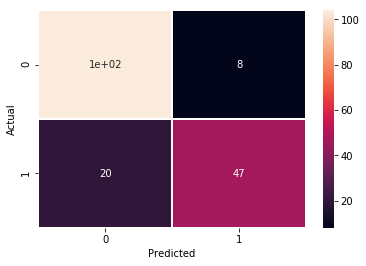

In [325]:
conf = confusion_matrix(y_label_test, gbc.predict(x_label_test))
sns.heatmap(conf, linewidths = 0.5, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')

In [308]:
#Predicting the test_label model on Gradient Boosting Model
gbc.predict(label_test)

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0,
       0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0,
       1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0,

In [309]:
# Making another set of models based on dummy encoding of the dataset
dummy_train = raw_train
dummy_test = raw_test

In [310]:
dummy_train.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Family_members,Is_alone,Has_cabin,Title
PassengerId,,,,,,,,,,
1,0,3,1,22.0,7.2500,2,2,0,1,2
2,1,1,0,38.0,71.2833,0,2,0,0,3
3,1,3,0,26.0,7.9250,2,1,1,1,1
4,1,1,0,35.0,53.1000,2,2,0,0,3
5,0,3,1,35.0,8.0500,2,1,1,1,2


In [311]:
pclass_dummy = pd.get_dummies(dummy_train.Pclass, prefix = 'Pclass')
pclass_dummy.drop(pclass_dummy.columns[0], axis=1, inplace=True)

embarked_dummy = pd.get_dummies(dummy_train.Embarked, prefix = 'Embarked')
embarked_dummy.drop(embarked_dummy.columns[0], axis=1, inplace=True)

family_dummy = pd.get_dummies(dummy_train.Family_members, prefix = 'Family_members')
family_dummy.drop(family_dummy.columns[0], axis=1, inplace=True)

title_dummy = pd.get_dummies(dummy_train.Pclass, prefix = 'Title')
title_dummy.drop(title_dummy.columns[0], axis=1, inplace=True)

dummy_train = pd.concat([dummy_train, pclass_dummy, embarked_dummy, title_dummy], axis=1)
dummy_train.drop(['Pclass', 'Embarked', 'Family_members', 'Title'], axis = 1, inplace= True)

In [312]:
dummy_train.head()

,Survived,Sex,Age,Fare,Is_alone,Has_cabin,Pclass_2,Pclass_3,Embarked_1,Embarked_2,Title_2,Title_3
PassengerId,,,,,,,,,,,,
1,0,1,22.0,7.2500,0,1,0,1,0,1,0,1
2,1,0,38.0,71.2833,0,0,0,0,0,0,0,0
3,1,0,26.0,7.9250,1,1,0,1,0,1,0,1
4,1,0,35.0,53.1000,0,0,0,0,0,1,0,0
5,0,1,35.0,8.0500,1,1,0,1,0,1,0,1


In [313]:
# Train_test_split on dummy model
x_dummy = dummy_train.drop('Survived', axis = 1)
y_dummy = dummy_train.Survived
x_dummy_train, x_dummy_test, y_dummy_train, y_dummy_test = train_test_split(x_dummy, y_dummy, test_size = 0.3)

In [314]:
# Logistic Regression Model on dummy model
lr_dummy = LogisticRegression(C=1)
lr_dummy.fit(x_dummy_train, y_dummy_train)
print("Accuracy of Logit Model on dummy_train:",accuracy_score(y_dummy_train, lr_dummy.predict(x_dummy_train)))
print("Accuracy of Logit Model on dummy_test:",accuracy_score(y_dummy_test, lr_dummy.predict(x_dummy_test)))

score_lr_dummy = cross_val_score(lr_dummy, x_dummy.values, y_dummy.values, cv=5)
print("Cross Validation score : " + str(score_lr_dummy))
print("Cross Validation Mean score : " + str(score_lr_dummy.mean()))

Accuracy of Logit Model on dummy_train: 0.791332263242
Accuracy of Logit Model on dummy_test: 0.850746268657
Cross Validation score : [ 0.79888268  0.80446927  0.80337079  0.78089888  0.83050847]
Cross Validation Mean score : 0.803626018561


In [315]:
# Decision Tree Model for Dummy dataset
tree_dummy = DecisionTreeClassifier(criterion = 'entropy', max_depth = 11)
tree_dummy.fit(x_dummy_train, y_dummy_train)
print("Accuracy of Logit Model on dummy_train:",accuracy_score(y_dummy_train, tree_dummy.predict(x_dummy_train)))
print("Accuracy of Logit Model on dummy_test:",accuracy_score(y_dummy_test, tree_dummy.predict(x_dummy_test)))

score_tree_dummy = cross_val_score(tree_dummy, x_dummy.values, y_dummy.values, cv=5)
print("Cross Validation score : " + str(score_tree_dummy))
print("Cross Validation Mean score : " + str(score_tree_dummy.mean()))

Accuracy of Logit Model on dummy_train: 0.950240770465
Accuracy of Logit Model on dummy_test: 0.791044776119
Cross Validation score : [ 0.79888268  0.79888268  0.83146067  0.79213483  0.84180791]
Cross Validation Mean score : 0.81263375567


In [316]:
# Random Forest Model for dummy dataset
forest_dummy = RandomForestClassifier(criterion = 'entropy', n_estimators = 1000, max_depth = 5,
                                     min_samples_split = 3)
forest_dummy.fit(x_dummy_train, y_dummy_train)
print("Accuracy of Logit Model on dummy_train:",accuracy_score(y_dummy_train, forest_dummy.predict(x_dummy_train)))
print("Accuracy of Logit Model on dummy_test:",accuracy_score(y_dummy_test, forest_dummy.predict(x_dummy_test)))

score_forest_dummy = cross_val_score(forest_dummy, x_dummy.values, y_dummy.values, cv=5)
print("Cross Validation score : " + str(score_forest_dummy))
print("Cross Validation Mean score : " + str(score_forest_dummy.mean()))

Accuracy of Logit Model on dummy_train: 0.85393258427
Accuracy of Logit Model on dummy_test: 0.835820895522
Cross Validation score : [ 0.7877095   0.80446927  0.86516854  0.79213483  0.84180791]
Cross Validation Mean score : 0.818258010268


In [317]:
# Extra Trees Model for the dummy dataset
extra_dummy = ExtraTreesClassifier(criterion = 'entropy', n_estimators = 1000, max_depth = 5,
                                     min_samples_split = 3)
extra_dummy.fit(x_dummy_train, y_dummy_train)
print("Accuracy of Logit Model on dummy_train:",accuracy_score(y_dummy_train, extra_dummy.predict(x_dummy_train)))
print("Accuracy of Logit Model on dummy_test:",accuracy_score(y_dummy_test, extra_dummy.predict(x_dummy_test)))

score_extra_dummy = cross_val_score(extra_dummy, x_dummy.values, y_dummy.values, cv=5)
print("Cross Validation score : " + str(score_extra_dummy))
print("Cross Validation Mean score : " + str(score_extra_dummy.mean()))


Accuracy of Logit Model on dummy_train: 0.823434991974
Accuracy of Logit Model on dummy_test: 0.84328358209
Cross Validation score : [ 0.77094972  0.81005587  0.85393258  0.78651685  0.82485876]
Cross Validation Mean score : 0.809262756371


In [318]:
#KNN Model for the dummy model
knn_dummy= KNeighborsClassifier(n_neighbors = 29, weights = 'distance')
knn_dummy.fit(x_dummy_train, y_dummy_train)
print("Accuracy of Logit Model on dummy_train:",accuracy_score(y_dummy_train, knn_dummy.predict(x_dummy_train)))
print("Accuracy of Logit Model on dummy_test:",accuracy_score(y_dummy_test, knn_dummy.predict(x_dummy_test)))

score_knn_dummy = cross_val_score(knn_dummy, x_dummy.values, y_dummy.values, cv=5)
print("Cross Validation score : " + str(score_knn_dummy))
print("Cross Validation Mean score : " + str(score_knn_dummy.mean()))

Accuracy of Logit Model on dummy_train: 0.982343499197
Accuracy of Logit Model on dummy_test: 0.701492537313
Cross Validation score : [ 0.62569832  0.74860335  0.74157303  0.71348315  0.74011299]
Cross Validation Mean score : 0.713894170021


In [319]:
#SVC Model for the dummy model
svc_dummy = SVC(C = 1, kernel = 'sigmoid')
svc_dummy.fit(x_dummy_train, y_dummy_train)
print("Accuracy of Logit Model on dummy_train:",accuracy_score(y_dummy_train, svc_dummy.predict(x_dummy_train)))
print("Accuracy of Logit Model on dummy_test:",accuracy_score(y_dummy_test, svc_dummy.predict(x_dummy_test)))

score_svc_dummy = cross_val_score(svc_dummy, x_dummy.values, y_dummy.values, cv=5)
print("Cross Validation score : " + str(score_svc_dummy))
print("Cross Validation Mean score : " + str(score_svc_dummy.mean()))

Accuracy of Logit Model on dummy_train: 0.619582664526
Accuracy of Logit Model on dummy_test: 0.608208955224
Cross Validation score : [ 0.61452514  0.61452514  0.61797753  0.61797753  0.61581921]
Cross Validation Mean score : 0.61616490891
